<a href="https://colab.research.google.com/github/MrPhipps/Colabs/blob/main/Easy_Super_Deluxe_Single_Prompt_Multi_Run_Copy_of_Disco_Diffusion_v5_2_%5Bw_VR_Mode%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set Up

In [ ]:
#@title 1.1 Check GPU Status
import subprocess
simple_nvidia_smi_display = True#@param {type:"boolean"}
if simple_nvidia_smi_display:
  #!nvidia-smi
  nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_output)
else:
  #!nvidia-smi -i 0 -e 0
  nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_output)
  nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(nvidiasmi_ecc_note)

GPU 0: Tesla T4 (UUID: GPU-6251915e-2fe0-5eca-b968-c6ec8a67f43a)



In [ ]:
#@title 1.2 Prepare Folders
import subprocess, os, sys, ipykernel

def gitclone(url):
  res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def pipi(modulestr):
  res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def pipie(modulestr):
  res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def wget(url, outputdir):
  res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

try:
    from google.colab import drive
    print("Google Colab detected. Using Google Drive.")
    is_colab = True
    #@markdown If you connect your Google Drive, you can save the final image of each run on your drive.
    google_drive = True #@param {type:"boolean"}
    #@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
    save_models_to_google_drive = True #@param {type:"boolean"}
except:
    is_colab = False
    google_drive = False
    save_models_to_google_drive = False
    print("Google Colab not detected.")

if is_colab:
    if google_drive is True:
        drive.mount('/content/drive')
        root_path = '/content/drive/MyDrive/AI/Disco_Diffusion'
    else:
        root_path = '/content'
else:
    root_path = os.getcwd()

import os
def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

initDirPath = f'{root_path}/init_images'
createPath(initDirPath)
outDirPath = f'{root_path}/images_out'
createPath(outDirPath)

if is_colab:
    if google_drive and not save_models_to_google_drive or not google_drive:
        model_path = '/content/models'
        createPath(model_path)
    if google_drive and save_models_to_google_drive:
        model_path = f'{root_path}/models'
        createPath(model_path)
else:
    model_path = f'{root_path}/models'
    createPath(model_path)

# libraries = f'{root_path}/libraries'
# createPath(libraries)

Google Colab detected. Using Google Drive.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title ### 1.3 Install and import dependencies

import pathlib, shutil, os, sys

if not is_colab:
  # If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
  os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

PROJECT_DIR = os.path.abspath(os.getcwd())
USE_ADABINS = True

if is_colab:
  if google_drive is not True:
    root_path = f'/content'
    model_path = '/content/models'
else:
  root_path = os.getcwd()
  model_path = f'{root_path}/models'

model_256_downloaded = False
model_512_downloaded = False
model_secondary_downloaded = False

multipip_res = subprocess.run(['pip', 'install', 'lpips', 'datetime', 'timm', 'ftfy', 'einops', 'pytorch-lightning', 'omegaconf'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(multipip_res)


if is_colab:
  subprocess.run(['apt', 'install', 'imagemagick'], stdout=subprocess.PIPE).stdout.decode('utf-8')

try:
  from CLIP import clip
except:
  if not os.path.exists("CLIP"):
    gitclone("https://github.com/openai/CLIP")
  sys.path.append(f'{PROJECT_DIR}/CLIP')

#try:
#  from models import SLIP_VITB16, SLIP, SLIP_VITL16
#except:
#  if not os.path.exists("SLIP"):
#    gitclone("https://github.com/facebookresearch/SLIP")
#  sys.path.append(f'{PROJECT_DIR}/SLIP')

try:
  from guided_diffusion.script_util import create_model_and_diffusion
except:
  if not os.path.exists("guided-diffusion"):
    gitclone("https://github.com/crowsonkb/guided-diffusion")
  sys.path.append(f'{PROJECT_DIR}/guided-diffusion')

try:
  from resize_right import resize
except:
  if not os.path.exists("ResizeRight"):
    gitclone("https://github.com/assafshocher/ResizeRight.git")
  sys.path.append(f'{PROJECT_DIR}/ResizeRight')

try:
  import py3d_tools
except:
  if not os.path.exists('pytorch3d-lite'):
    gitclone("https://github.com/MSFTserver/pytorch3d-lite.git")
  sys.path.append(f'{PROJECT_DIR}/pytorch3d-lite')

try:
  from midas.dpt_depth import DPTDepthModel
except:
  if not os.path.exists('MiDaS'):
    gitclone("https://github.com/isl-org/MiDaS.git")
  if not os.path.exists('MiDaS/midas_utils.py'):
    shutil.move('MiDaS/utils.py', 'MiDaS/midas_utils.py')
  if not os.path.exists(f'{model_path}/dpt_large-midas-2f21e586.pt'):
    wget("https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt", model_path)
  sys.path.append(f'{PROJECT_DIR}/MiDaS')

try:
  sys.path.append(PROJECT_DIR)
  import disco_xform_utils as dxf
except:
  if not os.path.exists("disco-diffusion"):
    gitclone("https://github.com/alembics/disco-diffusion.git")
  if os.path.exists('disco_xform_utils.py') is not True:
    shutil.move('disco-diffusion/disco_xform_utils.py', 'disco_xform_utils.py')
  sys.path.append(PROJECT_DIR)

import torch
from dataclasses import dataclass
from functools import partial
import cv2
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
from resize_right import resize
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib
from functools import partial
if is_colab:
  os.chdir('/content')
  from google.colab import files
else:
  os.chdir(f'{PROJECT_DIR}')
from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# AdaBins stuff
if USE_ADABINS:
  try:
    from infer import InferenceHelper
  except:
    if os.path.exists("AdaBins") is not True:
      gitclone("https://github.com/shariqfarooq123/AdaBins.git")
    if not os.path.exists(f'{PROJECT_DIR}/pretrained/AdaBins_nyu.pt'):
      createPath(f'{PROJECT_DIR}/pretrained')
      wget("https://cloudflare-ipfs.com/ipfs/Qmd2mMnDLWePKmgfS8m6ntAg4nhV5VkUyAydYBp8cWWeB7/AdaBins_nyu.pt", f'{PROJECT_DIR}/pretrained')
    sys.path.append(f'{PROJECT_DIR}/AdaBins')
  from infer import InferenceHelper
  MAX_ADABINS_AREA = 500000

import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
device = DEVICE # At least one of the modules expects this name..

if torch.cuda.get_device_capability(DEVICE) == (8,0): ## A100 fix thanks to Emad
  print('Disabling CUDNN for A100 gpu', file=sys.stderr)
  torch.backends.cudnn.enabled = False


Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
#@title ### 1.4 Define Midas functions

from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet

# Initialize MiDaS depth model.
# It remains resident in VRAM and likely takes around 2GB VRAM.
# You could instead initialize it for each frame (and free it after each frame) to save VRAM.. but initializing it is slow.
default_models = {
    "midas_v21_small": f"{model_path}/midas_v21_small-70d6b9c8.pt",
    "midas_v21": f"{model_path}/midas_v21-f6b98070.pt",
    "dpt_large": f"{model_path}/dpt_large-midas-2f21e586.pt",
    "dpt_hybrid": f"{model_path}/dpt_hybrid-midas-501f0c75.pt",
    "dpt_hybrid_nyu": f"{model_path}/dpt_hybrid_nyu-2ce69ec7.pt",}


def init_midas_depth_model(midas_model_type="dpt_large", optimize=True):
    midas_model = None
    net_w = None
    net_h = None
    resize_mode = None
    normalization = None

    print(f"Initializing MiDaS '{midas_model_type}' depth model...")
    # load network
    midas_model_path = default_models[midas_model_type]

    if midas_model_type == "dpt_large": # DPT-Large
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitl16_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid": #DPT-Hybrid
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid_nyu": #DPT-Hybrid-NYU
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode="minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "midas_v21":
        midas_model = MidasNet(midas_model_path, non_negative=True)
        net_w, net_h = 384, 384
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    elif midas_model_type == "midas_v21_small":
        midas_model = MidasNet_small(midas_model_path, features=64, backbone="efficientnet_lite3", exportable=True, non_negative=True, blocks={'expand': True})
        net_w, net_h = 256, 256
        resize_mode="upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    else:
        print(f"midas_model_type '{midas_model_type}' not implemented")
        assert False

    midas_transform = T.Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method=resize_mode,
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

    midas_model.eval()

    if optimize==True:
        if DEVICE == torch.device("cuda"):
            midas_model = midas_model.to(memory_format=torch.channels_last)
            midas_model = midas_model.half()

    midas_model.to(DEVICE)

    print(f"MiDaS '{midas_model_type}' depth model initialized.")
    return midas_model, midas_transform, net_w, net_h, resize_mode, normalization

In [ ]:
#@title 1.5 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

import py3d_tools as p3dT
import disco_xform_utils as dxf

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

def regen_perlin():
    if perlin_mode == 'color':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == 'gray':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)

    init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
    del init2
    return init.expand(batch_size, -1, -1, -1)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(self.cutn):
            if ch > self.cutn - self.cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts

cutout_debug = False
padargs = {}

class MakeCutoutsDango(nn.Module):
    def __init__(self, cut_size,
                 Overview=4,
                 InnerCrop = 0, IC_Size_Pow=0.5, IC_Grey_P = 0.2
                 ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        if args.animation_mode == 'None':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif args.animation_mode == 'Video Input':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomPerspective(distortion_scale=0.4, p=0.7),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.15),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif  args.animation_mode == '2D' or args.animation_mode == '3D':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.4),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.3),
          ])


    def forward(self, input):
        cutouts = []
        gray = T.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [1,3,self.cut_size,self.cut_size]
        output_shape_2 = [1,3,self.cut_size+2,self.cut_size+2]
        pad_input = F.pad(input,((sideY-max_size)//2,(sideY-max_size)//2,(sideX-max_size)//2,(sideX-max_size)//2), **padargs)
        cutout = resize(pad_input, out_shape=output_shape)

        if self.Overview>0:
            if self.Overview<=4:
                if self.Overview>=1:
                    cutouts.append(cutout)
                if self.Overview>=2:
                    cutouts.append(gray(cutout))
                if self.Overview>=3:
                    cutouts.append(TF.hflip(cutout))
                if self.Overview==4:
                    cutouts.append(gray(TF.hflip(cutout)))
            else:
                cutout = resize(pad_input, out_shape=output_shape)
                for _ in range(self.Overview):
                    cutouts.append(cutout)

            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("/content/cutout_overview0.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("cutout_overview0.jpg",quality=99)


        if self.InnerCrop >0:
            for i in range(self.InnerCrop):
                size = int(torch.rand([])**self.IC_Size_Pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                if i <= int(self.IC_Grey_P * self.InnerCrop):
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                if is_colab:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("/content/cutout_InnerCrop.jpg",quality=99)
                else:
                    TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("cutout_InnerCrop.jpg",quality=99)
        cutouts = torch.cat(cutouts)
        if skip_augs is not True: cutouts=self.augs(cutouts)
        return cutouts

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete
TRANSLATION_SCALE = 1.0/200.0

def do_3d_step(img_filepath, frame_num, midas_model, midas_transform):
  if args.key_frames:
    translation_x = args.translation_x_series[frame_num]
    translation_y = args.translation_y_series[frame_num]
    translation_z = args.translation_z_series[frame_num]
    rotation_3d_x = args.rotation_3d_x_series[frame_num]
    rotation_3d_y = args.rotation_3d_y_series[frame_num]
    rotation_3d_z = args.rotation_3d_z_series[frame_num]
    print(
        f'translation_x: {translation_x}',
        f'translation_y: {translation_y}',
        f'translation_z: {translation_z}',
        f'rotation_3d_x: {rotation_3d_x}',
        f'rotation_3d_y: {rotation_3d_y}',
        f'rotation_3d_z: {rotation_3d_z}',
    )

  translate_xyz = [-translation_x*TRANSLATION_SCALE, translation_y*TRANSLATION_SCALE, -translation_z*TRANSLATION_SCALE]
  rotate_xyz_degrees = [rotation_3d_x, rotation_3d_y, rotation_3d_z]
  print('translation:',translate_xyz)
  print('rotation:',rotate_xyz_degrees)
  rotate_xyz = [math.radians(rotate_xyz_degrees[0]), math.radians(rotate_xyz_degrees[1]), math.radians(rotate_xyz_degrees[2])]
  rot_mat = p3dT.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
  print("rot_mat: " + str(rot_mat))
  next_step_pil = dxf.transform_image_3d(img_filepath, midas_model, midas_transform, DEVICE,
                                          rot_mat, translate_xyz, args.near_plane, args.far_plane,
                                          args.fov, padding_mode=args.padding_mode,
                                          sampling_mode=args.sampling_mode, midas_weight=args.midas_weight)
  return next_step_pil

def do_run():
  seed = args.seed
  print(range(args.start_frame, args.max_frames))

  if (args.animation_mode == "3D") and (args.midas_weight > 0.0):
      midas_model, midas_transform, midas_net_w, midas_net_h, midas_resize_mode, midas_normalization = init_midas_depth_model(args.midas_depth_model)
  for frame_num in range(args.start_frame, args.max_frames):
      if stop_on_next_loop:
        break

      display.clear_output(wait=True)

      # Print Frame progress if animation mode is on
      if args.animation_mode != "None":
        batchBar = tqdm(range(args.max_frames), desc ="Frames")
        batchBar.n = frame_num
        batchBar.refresh()


      # Inits if not video frames
      if args.animation_mode != "Video Input":
        if args.init_image == '':
          init_image = None
        else:
          init_image = args.init_image
        init_scale = args.init_scale
        skip_steps = args.skip_steps

      if args.animation_mode == "2D":
        if args.key_frames:
          angle = args.angle_series[frame_num]
          zoom = args.zoom_series[frame_num]
          translation_x = args.translation_x_series[frame_num]
          translation_y = args.translation_y_series[frame_num]
          print(
              f'angle: {angle}',
              f'zoom: {zoom}',
              f'translation_x: {translation_x}',
              f'translation_y: {translation_y}',
          )

        if frame_num > 0:
          seed += 1
          if resume_run and frame_num == start_frame:
            img_0 = cv2.imread(batchFolder+f"/{batch_name}({batchNum})_{start_frame-1:04}.png")
          else:
            img_0 = cv2.imread('prevFrame.png')
          center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
          trans_mat = np.float32(
              [[1, 0, translation_x],
              [0, 1, translation_y]]
          )
          rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )
          trans_mat = np.vstack([trans_mat, [0,0,1]])
          rot_mat = np.vstack([rot_mat, [0,0,1]])
          transformation_matrix = np.matmul(rot_mat, trans_mat)
          img_0 = cv2.warpPerspective(
              img_0,
              transformation_matrix,
              (img_0.shape[1], img_0.shape[0]),
              borderMode=cv2.BORDER_WRAP
          )

          cv2.imwrite('prevFrameScaled.png', img_0)
          init_image = 'prevFrameScaled.png'
          init_scale = args.frames_scale
          skip_steps = args.calc_frames_skip_steps

      if args.animation_mode == "3D":
        if frame_num > 0:
          seed += 1
          if resume_run and frame_num == start_frame:
            img_filepath = batchFolder+f"/{batch_name}({batchNum})_{start_frame-1:04}.png"
            if turbo_mode and frame_num > turbo_preroll:
              shutil.copyfile(img_filepath, 'oldFrameScaled.png')
          else:
            img_filepath = '/content/prevFrame.png' if is_colab else 'prevFrame.png'

          next_step_pil = do_3d_step(img_filepath, frame_num, midas_model, midas_transform)
          next_step_pil.save('prevFrameScaled.png')

          ### Turbo mode - skip some diffusions, use 3d morph for clarity and to save time
          if turbo_mode:
            if frame_num == turbo_preroll: #start tracking oldframe
              next_step_pil.save('oldFrameScaled.png')#stash for later blending
            elif frame_num > turbo_preroll:
              #set up 2 warped image sequences, old & new, to blend toward new diff image
              old_frame = do_3d_step('oldFrameScaled.png', frame_num, midas_model, midas_transform)
              old_frame.save('oldFrameScaled.png')
              if frame_num % int(turbo_steps) != 0:
                print('turbo skip this frame: skipping clip diffusion steps')
                filename = f'{args.batch_name}({args.batchNum})_{frame_num:04}.png'
                blend_factor = ((frame_num % int(turbo_steps))+1)/int(turbo_steps)
                print('turbo skip this frame: skipping clip diffusion steps and saving blended frame')
                newWarpedImg = cv2.imread('prevFrameScaled.png')#this is already updated..
                oldWarpedImg = cv2.imread('oldFrameScaled.png')
                blendedImage = cv2.addWeighted(newWarpedImg, blend_factor, oldWarpedImg,1-blend_factor, 0.0)
                cv2.imwrite(f'{batchFolder}/{filename}',blendedImage)
                next_step_pil.save(f'{img_filepath}') # save it also as prev_frame to feed next iteration
                continue
              else:
                #if not a skip frame, will run diffusion and need to blend.
                oldWarpedImg = cv2.imread('prevFrameScaled.png')
                cv2.imwrite(f'oldFrameScaled.png',oldWarpedImg)#swap in for blending later
                print('clip/diff this frame - generate clip diff image')

          init_image = 'prevFrameScaled.png'
          init_scale = args.frames_scale
          skip_steps = args.calc_frames_skip_steps

      if  args.animation_mode == "Video Input":
        if not video_init_seed_continuity:
          seed += 1
        init_image = f'{videoFramesFolder}/{frame_num+1:04}.jpg'
        init_scale = args.frames_scale
        skip_steps = args.calc_frames_skip_steps

      loss_values = []

      if seed is not None:
          np.random.seed(seed)
          random.seed(seed)
          torch.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
          torch.backends.cudnn.deterministic = True

      target_embeds, weights = [], []

      if args.prompts_series is not None and frame_num >= len(args.prompts_series):
        frame_prompt = args.prompts_series[-1]
      elif args.prompts_series is not None:
        frame_prompt = args.prompts_series[frame_num]
      else:
        frame_prompt = []

      print(args.image_prompts_series)
      if args.image_prompts_series is not None and frame_num >= len(args.image_prompts_series):
        image_prompt = args.image_prompts_series[-1]
      elif args.image_prompts_series is not None:
        image_prompt = args.image_prompts_series[frame_num]
      else:
        image_prompt = []

      print(f'Frame {frame_num} Prompt: {frame_prompt}')

      model_stats = []
      for clip_model in clip_models:
            cutn = 16
            model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
            model_stat["clip_model"] = clip_model


            for prompt in frame_prompt:
                txt, weight = parse_prompt(prompt)
                txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

                if args.fuzzy_prompt:
                    for i in range(25):
                        model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * args.rand_mag).clamp(0,1))
                        model_stat["weights"].append(weight)
                else:
                    model_stat["target_embeds"].append(txt)
                    model_stat["weights"].append(weight)

            if image_prompt:
              model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs)
              for prompt in image_prompt:
                  path, weight = parse_prompt(prompt)
                  img = Image.open(fetch(path)).convert('RGB')
                  img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
                  batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
                  embed = clip_model.encode_image(normalize(batch)).float()
                  if fuzzy_prompt:
                      for i in range(25):
                          model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                          weights.extend([weight / cutn] * cutn)
                  else:
                      model_stat["target_embeds"].append(embed)
                      model_stat["weights"].extend([weight / cutn] * cutn)

            model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
            model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
            if model_stat["weights"].sum().abs() < 1e-3:
                raise RuntimeError('The weights must not sum to 0.')
            model_stat["weights"] /= model_stat["weights"].sum().abs()
            model_stats.append(model_stat)

      init = None
      if init_image is not None:
          init = Image.open(fetch(init_image)).convert('RGB')
          init = init.resize((args.side_x, args.side_y), Image.LANCZOS)
          init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

      if args.perlin_init:
          if args.perlin_mode == 'color':
              init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
              init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
          elif args.perlin_mode == 'gray':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          else:
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          # init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
          init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
          del init2

      cur_t = None

      def cond_fn(x, t, y=None):
          with torch.enable_grad():
              x_is_NaN = False
              x = x.detach().requires_grad_()
              n = x.shape[0]
              if use_secondary_model is True:
                alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                cosine_t = alpha_sigma_to_t(alpha, sigma)
                out = secondary_model(x, cosine_t[None].repeat([n])).pred
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              else:
                my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out['pred_xstart'] * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              for model_stat in model_stats:
                for i in range(args.cutn_batches):
                    t_int = int(t.item())+1 #errors on last step without +1, need to find source
                    #when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                    try:
                        input_resolution=model_stat["clip_model"].visual.input_resolution
                    except:
                        input_resolution=224

                    cuts = MakeCutoutsDango(input_resolution,
                            Overview= args.cut_overview[1000-t_int],
                            InnerCrop = args.cut_innercut[1000-t_int], IC_Size_Pow=args.cut_ic_pow, IC_Grey_P = args.cut_icgray_p[1000-t_int]
                            )
                    clip_in = normalize(cuts(x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([args.cut_overview[1000-t_int]+args.cut_innercut[1000-t_int], n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
              tv_losses = tv_loss(x_in)
              if use_secondary_model is True:
                range_losses = range_loss(out)
              else:
                range_losses = range_loss(out['pred_xstart'])
              sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
              loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
              if init is not None and args.init_scale:
                  init_losses = lpips_model(x_in, init)
                  loss = loss + init_losses.sum() * args.init_scale
              x_in_grad += torch.autograd.grad(loss, x_in)[0]
              if torch.isnan(x_in_grad).any()==False:
                  grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
              else:
                # print("NaN'd")
                x_is_NaN = True
                grad = torch.zeros_like(x)
          if args.clamp_grad and x_is_NaN == False:
              magnitude = grad.square().mean().sqrt()
              return grad * magnitude.clamp(max=args.clamp_max) / magnitude  #min=-0.02, min=-clamp_max,
          return grad

      if args.diffusion_sampling_mode == 'ddim':
          sample_fn = diffusion.ddim_sample_loop_progressive
      else:
          sample_fn = diffusion.plms_sample_loop_progressive


      image_display = Output()
      for i in range(args.n_batches):
          if args.animation_mode == 'None':
            display.clear_output(wait=True)
            batchBar = tqdm(range(args.n_batches), desc ="Batches")
            batchBar.n = i
            batchBar.refresh()
          print('')
          display.display(image_display)
          gc.collect()
          torch.cuda.empty_cache()
          cur_t = diffusion.num_timesteps - skip_steps - 1
          total_steps = cur_t

          if perlin_init:
              init = regen_perlin()

          if args.diffusion_sampling_mode == 'ddim':
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
                  eta=eta,
              )
          else:
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
                  order=2,
              )


          # with run_display:
          # display.clear_output(wait=True)
          for j, sample in enumerate(samples):
            cur_t -= 1
            intermediateStep = False
            if args.steps_per_checkpoint is not None:
                if j % steps_per_checkpoint == 0 and j > 0:
                  intermediateStep = True
            elif j in args.intermediate_saves:
              intermediateStep = True
            with image_display:
              if j % args.display_rate == 0 or cur_t == -1 or intermediateStep == True:
                  for k, image in enumerate(sample['pred_xstart']):
                      # tqdm.write(f'Batch {i}, step {j}, output {k}:')
                      current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                      percent = math.ceil(j/total_steps*100)
                      if args.n_batches > 0:
                        #if intermediates are saved to the subfolder, don't append a step or percentage to the name
                        if cur_t == -1 and args.intermediates_in_subfolder is True:
                          save_num = f'{frame_num:04}' if animation_mode != "None" else i
                          filename = f'{args.batch_name}({args.batchNum})_{save_num}.png'
                        else:
                          #If we're working with percentages, append it
                          if args.steps_per_checkpoint is not None:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{percent:02}%.png'
                          # Or else, iIf we're working with specific steps, append those
                          else:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{j:03}.png'
                      image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                      if j % args.display_rate == 0 or cur_t == -1:
                        image.save('progress.png')
                        display.clear_output(wait=True)
                        display.display(display.Image('progress.png'))
                      if args.steps_per_checkpoint is not None:
                        if j % args.steps_per_checkpoint == 0 and j > 0:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      else:
                        if j in args.intermediate_saves:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      if cur_t == -1:
                        if frame_num == 0:
                          save_settings()
                        if args.animation_mode != "None":
                          image.save('prevFrame.png')
                        image.save(f'{batchFolder}/{filename}')
                        if args.animation_mode == "3D":
                          # If turbo, save a blended image
                          if turbo_mode and frame_num > 0:
                            # Mix new image with prevFrameScaled
                            blend_factor = (1)/int(turbo_steps)
                            newFrame = cv2.imread('prevFrame.png') # This is already updated..
                            prev_frame_warped = cv2.imread('prevFrameScaled.png')
                            blendedImage = cv2.addWeighted(newFrame, blend_factor, prev_frame_warped, (1-blend_factor), 0.0)
                            cv2.imwrite(f'{batchFolder}/{filename}',blendedImage)
                          else:
                            image.save(f'{batchFolder}/{filename}')

                          if vr_mode:
                            generate_eye_views(TRANSLATION_SCALE, batchFolder, filename, frame_num, midas_model, midas_transform)

                        # if frame_num != args.max_frames-1:
                        #   display.clear_output()

          plt.plot(np.array(loss_values), 'r')

def generate_eye_views(trans_scale,batchFolder,filename,frame_num,midas_model, midas_transform):
   for i in range(2):
      theta = vr_eye_angle * (math.pi/180)
      ray_origin = math.cos(theta) * vr_ipd / 2 * (-1.0 if i==0 else 1.0)
      ray_rotation = (theta if i==0 else -theta)
      translate_xyz = [-(ray_origin)*trans_scale, 0,0]
      rotate_xyz = [0, (ray_rotation), 0]
      rot_mat = p3dT.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
      transformed_image = dxf.transform_image_3d(f'{batchFolder}/{filename}', midas_model, midas_transform, DEVICE,
                                                      rot_mat, translate_xyz, args.near_plane, args.far_plane,
                                                      args.fov, padding_mode=args.padding_mode,
                                                      sampling_mode=args.sampling_mode, midas_weight=args.midas_weight,spherical=True)
      eye_file_path = batchFolder+f"/frame_{frame_num-1:04}" + ('_l' if i==0 else '_r')+'.png'
      transformed_image.save(eye_file_path)

def save_settings():
  setting_list = {
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    # 'cutn': cutn,
    'cutn_batches': cutn_batches,
    'max_frames': max_frames,
    'interp_spline': interp_spline,
    # 'rotation_per_frame': rotation_per_frame,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    # 'zoom_per_frame': zoom_per_frame,
    'frames_scale': frames_scale,
    'frames_skip_steps': frames_skip_steps,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'seed': seed,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
    'eta': eta,
    'width': width_height[0],
    'height': width_height[1],
    'diffusion_model': diffusion_model,
    'use_secondary_model': use_secondary_model,
    'steps': steps,
    'diffusion_steps': diffusion_steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'ViTB32': ViTB32,
    'ViTB16': ViTB16,
    'ViTL14': ViTL14,
    'RN101': RN101,
    'RN50': RN50,
    'RN50x4': RN50x4,
    'RN50x16': RN50x16,
    'RN50x64': RN50x64,
    'cut_overview': str(cut_overview),
    'cut_innercut': str(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': str(cut_icgray_p),
    'key_frames': key_frames,
    'max_frames': max_frames,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'video_init_path':video_init_path,
    'extract_nth_frame':extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'turbo_mode':turbo_mode,
    'turbo_steps':turbo_steps,
    'turbo_preroll':turbo_preroll,
  }
  # print('Settings:', setting_list)
  with open(f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+") as f:   #save settings
    json.dump(setting_list, f, ensure_ascii=False, indent=4)

In [ ]:
#@title 1.6 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)

# 2. Diffusion and CLIP model settings

In [ ]:
#@markdown ####**Models Settings:**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100"]
use_secondary_model = True #@param {type: 'boolean'}
diffusion_sampling_mode = 'plms' #@param ['plms','ddim']


use_checkpoint = True #@param {type: 'boolean'}

ViTB32 = True #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
RN50x4 = True #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}
ViTL14 = True #@param{type:"boolean"}

#SLIPB16 = False #@param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

model_256_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'
model_512_SHA = '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648'
model_secondary_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'

model_256_link = 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'
model_512_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/512x512_diffusion_uncond_finetune_008100.pt'
model_secondary_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth'

model_256_path = f'{model_path}/256x256_diffusion_uncond.pt'
model_512_path = f'{model_path}/512x512_diffusion_uncond_finetune_008100.pt'
model_secondary_path = f'{model_path}/secondary_model_imagenet_2.pth'

# Download the diffusion model
if diffusion_model == '256x256_diffusion_uncond':
  if os.path.exists(model_256_path) and check_model_SHA:
    print('Checking 256 Diffusion File')
    with open(model_256_path,"rb") as f:
        bytes = f.read()
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_256_SHA:
      print('256 Model SHA matches')
      model_256_downloaded = True
    else:
      print("256 Model SHA doesn't match, redownloading...")
      wget(model_256_link, model_path)
      model_256_downloaded = True
  elif os.path.exists(model_256_path) and not check_model_SHA or model_256_downloaded == True:
    print('256 Model already downloaded, check check_model_SHA if the file is corrupt')
  else:
    wget(model_256_link, model_path)
    model_256_downloaded = True
elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
  if os.path.exists(model_512_path) and check_model_SHA:
    print('Checking 512 Diffusion File')
    with open(model_512_path,"rb") as f:
        bytes = f.read()
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_512_SHA:
      print('512 Model SHA matches')
      model_512_downloaded = True
    else:
      print("512 Model SHA doesn't match, redownloading...")
      wget(model_512_link, model_path)
      model_512_downloaded = True
  elif os.path.exists(model_512_path) and not check_model_SHA or model_512_downloaded == True:
    print('512 Model already downloaded, check check_model_SHA if the file is corrupt')
  else:
    wget(model_512_link, model_path)
    model_512_downloaded = True


# Download the secondary diffusion model v2
if use_secondary_model == True:
  if os.path.exists(model_secondary_path) and check_model_SHA:
    print('Checking Secondary Diffusion File')
    with open(model_secondary_path,"rb") as f:
        bytes = f.read()
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_secondary_SHA:
      print('Secondary Model SHA matches')
      model_secondary_downloaded = True
    else:
      print("Secondary Model SHA doesn't match, redownloading...")
      wget(model_secondary_link, model_path)
      model_secondary_downloaded = True
  elif os.path.exists(model_secondary_path) and not check_model_SHA or model_secondary_downloaded == True:
    print('Secondary Model already downloaded, check check_model_SHA if the file is corrupt')
  else:
    wget(model_secondary_link, model_path)
    model_secondary_downloaded = True

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

model_default = model_config['image_size']



if use_secondary_model:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
    secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32 is True: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB16 is True: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device) )
if ViTL14 is True: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device) )
if RN50 is True: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4 is True: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x16 is True: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x64 is True: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device))
if RN101 is True: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device))

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512 Model already downloaded, check check_model_SHA if the file is corrupt
Secondary Model already downloaded, check check_model_SHA if the file is corrupt


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.5MiB/s]
100%|███████████████████████████████████████| 335M/335M [00:11<00:00, 30.9MiB/s]
100%|███████████████████████████████████████| 890M/890M [00:38<00:00, 24.2MiB/s]
100%|███████████████████████████████████████| 244M/244M [00:06<00:00, 38.5MiB/s]
100%|███████████████████████████████████████| 402M/402M [01:00<00:00, 7.03MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.8MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


# Helper Monkeys

In [ ]:
#@title
desired_frames_run = 800 #@param{type: 'number'}
step_in_percentage = 10 #@param {type:"slider", min:0.0, max:100.0, step:1}
needed_steps = desired_frames_run / -((step_in_percentage - 100.00) / 100.00)

print(f'{needed_steps}')
print(f'{needed_steps - desired_frames_run}')

888.8888888888889
88.88888888888891


In [ ]:
#@title
#@title

mediumPrompt = "high resolution photo-microscopy image"#@param{type:'string'}
subjectPrompt = "crystalline structures and coral"#@param{type:'string'}
prepositionalPrompt = "forming a momento mori"#@param{type:'string'}
artistPrompts = ""#@param{type:'string'}
metaPrompts = "colorful | beautiful | Dia de los Muertos candy skull"#@param{type:'string'}


text_prompts = {
0:[
# Medium
mediumPrompt + " " +

#subject
subjectPrompt + " " +

#prepositional details
prepositionalPrompt + " " +

#artist
artistPrompts + " " +

#meta modifiers
metaPrompts

],}

image_prompts = {}

In [ ]:
#@title
print(f'{text_prompts}')

{0: ["cross-stitch wallhanging the people's international revolutionary soundsystem  performing concert for rebels  in a high contrast punk rock Xerographic collage  rock poster by Ghanaian graphic designer  | riot and revolution | soundclash | speakerbox | bassbins  "]}


#Global Settings

In [ ]:
#@title
#@markdown ### **Global Basic Settings:**

base_batch_name = 'destroyAll_PIRSS_CROSSSTITCH' #@param{type: 'string'}

use_global_steps = True#@param{type: 'boolean'}
global_steps = 1000#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}

use_global_width_height = True#@param{type: 'boolean'}
global_width_height = [1024, 1024]#@param{type: 'raw'}

use_global_clip_guidance_scale = True#@param{type: 'boolean'}
global_clip_guidance_scale = 10000#@param{type: 'number'}

use_global_tv_scale = True#@param{type: 'boolean'}
global_tv_scale = 0#@param{type: 'number'}

use_global_range_scale = True#@param{type: 'boolean'}
global_range_scale = 23#@param{type: 'number'}

use_global_sat_scale = True#@param{type: 'boolean'}
global_sat_scale =   0#@param{type: 'number'}

use_global_cutn_batches = True#@param{type: 'boolean'}
global_cutn_batches = 2#@param{type: 'number'}

use_global_skip_augs = True#@param{type: 'boolean'}
global_skip_augs = True#@param{type: 'boolean'}

#@markdown ---
#@markdown

#@markdown ### **Global Image Init Settings:**
use_global_init_image = True#@param{type: 'boolean'}
global_init_image = "" #@param{type: 'string'}

use_global_init_scale = False#@param{type: 'boolean'}
global_init_scale =  1418#@param{type: 'integer'}

use_global_skip_steps = False#@param{type: 'boolean'}
global_skip_steps =  127#@param{type: 'integer'}
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#@markdown ### **Global Advanced Settings**
use_global_set_seed = True#@param{type: 'boolean'}
global_set_seed = '2323232323' #@param{type: 'string'}

#@markdown ---
#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000
#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.
use_global_cut_overview = True#@param{type: 'boolean'}
global_cut_overview = "[16]*100+[14]*100+[12]*100+[10]*100+[8]*100+[6]*100+[4]*100+[2]*100+[0]*100+[1]*100" #@param {type: 'string'}

use_global_cut_innercut = True#@param{type: 'boolean'}
global_cut_innercut ="[0]*100+[2]*100+[4]*100+[6]*100+[8]*100+[10]*100+[12]*100+[14]*100+[16]*100+[4]*100"#@param {type: 'string'}

use_global_cut_ic_pow = True#@param{type: 'boolean'}
global_cut_ic_pow = 4.0#@param {type: 'number'}

use_global_cut_icgray_p = True#@param{type: 'boolean'}
global_cut_icgray_p = "[0.999]*100+[0.333]*200+[0.0333]*700"#@param {type: 'string'}

use_global_eta = True#@param{type: 'boolean'}
global_eta = 0.33#@param{type:"slider", min:0.0, max:1.0, step:0.01}

use_global_clamp_grad = True#@param{type: 'boolean'}
global_clamp_grad = True #@param{type: 'boolean'}

use_global_clamp_max = True#@param{type: 'boolean'}
global_clamp_max = 0.887 #@param{type:"slider", min:0.0, max:1.0, step:0.001}

use_global_randomize_class = True #@param{type: 'boolean'}
global_randomize_class = True #@param{type: 'boolean'}

use_global_clip_denoised = True#@param{type: 'boolean'}
global_clip_denoised = True #@param{type: 'boolean'}

use_global_fuzzy_prompt = True#@param{type: 'boolean'}
global_fuzzy_prompt = True #@param{type: 'boolean'}

use_global_rand_mag = True#@param{type: 'boolean'}
global_rand_mag = 0.95 #@param{type:"slider", min:0.0, max:1.0, step:0.01}




# 3. 1st Batch Settings

In [ ]:
#@title
#@markdown ####**Basic Settings:**
suffix_batch_name = "_images"#@param{type: 'string'}
batch_name = f'{base_batch_name}_1st_{suffix_batch_name}'

local_steps = 200#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
steps = global_steps if use_global_steps else local_steps

local_width_height = [1024, 1024]#@param{type: 'raw'}
width_height = global_width_height if use_global_width_height else local_width_height

local_clip_guidance_scale =  50000#@param{type: 'number'}
clip_guidance_scale =  global_clip_guidance_scale if use_global_clip_guidance_scale else local_clip_guidance_scale

if use_global_tv_scale:
  local_tv_scale =  "GLOBAL"#@param{type: 'string'}
else:
 local_tv_scale =  50#@param{type: 'number'}


tv_scale =  global_tv_scale if use_global_tv_scale else local_tv_scale

local_range_scale = 0#@param{type: 'number'}
range_scale = global_range_scale if use_global_range_scale else local_range_scale

local_sat_scale = 0#@param{type: 'number'}
sat_scale = global_sat_scale if use_global_sat_scale else local_sat_scale

local_cutn_batches =   1#@param{type: 'number'}
cutn_batches =   global_cutn_batches if use_global_cutn_batches else local_cutn_batches

local_skip_augs = False#@param{type: 'boolean'}
skip_augs = global_skip_augs if use_global_skip_augs else local_skip_augs

#@markdown ---

#@markdown ####**Init Settings:**
local_init_image = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/SunsetClouds01.png" #@param{type: 'string'}
init_image = global_init_image if use_global_init_image else local_init_image

local_init_scale =  2000#@param{type: 'integer'}
init_scale = global_init_scale if use_global_init_scale else local_init_scale

local_skip_steps =  50#@param{type: 'integer'}
skip_steps = global_skip_steps if use_global_skip_steps else local_skip_steps
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
createPath(batchFolder)

### Animation Settings

In [ ]:
#@title
#@markdown ####**Animation Mode:**
animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input'] {type:'string'}
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
if is_colab:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/ColoredNoise_120bpm_2frameIntroPad.mov" #@param {type: 'string'}
else:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/IMG_1170_trimmed_1.mp4" #@param {type: 'string'}
extract_nth_frame =  1#@param {type: 'number'}
video_init_seed_continuity = True #@param {type: 'boolean'}

if animation_mode == "Video Input":
  if is_colab:
      videoFramesFolder = f'/content/videoFrames'
  else:
      videoFramesFolder = f'videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    for f in pathlib.Path(f'{videoFramesFolder}').glob('*.jpg'):
      f.unlink()
  except:
    print('')
  vf = f'select=not(mod(n\,{extract_nth_frame}))'
  subprocess.run(['ffmpeg', '-i', f'{video_init_path}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
#@markdown All rotations are provided in degrees.

key_frames = True #@param {type:"boolean"}
max_frames = 60#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))


interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0: (0.0),"#@param {type:"string"}
zoom = "6:(1.0),53:(1.10),"#@param {type:"string"}
translation_x = "0: (0.0),"#@param {type:"string"}
translation_y = "0: (0.0),"#@param {type:"string"}
translation_z = "0:(0.0),"#@param {type:"string"}
rotation_3d_x = "0: (0.0),"#@param {type:"string"}
rotation_3d_y = "0:(0.0),"#@param {type:"string"}
rotation_3d_z = "0:(0.0),"#@param {type:"string"}
midas_depth_model = "dpt_large"#@param {type:"string"}
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 50000 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '63%' #@param ['15%', '30%', '33%' '40%', '50%', '60%', '66%', '70%', '80%', '85%'] {type: 'string'}

#======= TURBO MODE
#@markdown ---
#@markdown ####**Turbo Mode (3D anim only):**
#@markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
#@markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames. frame_blend_mode smooths abrupt texture changes across 2 frames.
#@markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = False #@param {type:"boolean"}
turbo_steps = "2" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames

#======= VR MODE
#@markdown ---
#@markdown ####**VR Mode (3D anim only):**
#@markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.
#@markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
#@markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
#@markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
#@markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
#@markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
#@markdown
#@markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False #@param {type:"boolean"}
#@markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5 #@param{type:"number"}
#@markdown interpupillary distance (between the eyes)
vr_ipd = 5.0 #@param{type:"number"}

#insist turbo be used only w 3d anim.
if vr_mode and animation_mode != '3D':
  print('=====')
  print('VR mode only available with 3D animations. Disabling VR.')
  print('=====')
  turbo_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.

    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.

    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.

    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.

    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'

    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'


    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

<ipython-input-18-85a14f5b736b>:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  key_frame_series[i] = value
<ipython-input-18-85a14f5b736b>:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  key_frame_series[i] = value
<ipython-input-18-85a14f5b736b>:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  key_frame_series[i] = value
<ipython-input-18-85a14f5b736b>:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in

### Advanced Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [ ]:
#@title
#@markdown #**Advanced Settings**
local_set_seed = '80808' #@param{type: 'string'}
set_seed = global_set_seed if use_global_set_seed else local_set_seed

#@markdown ---
#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000
#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.
local_cut_overview = "[16]*300+[4]*700" #@param {type: 'string'}
cut_overview = global_cut_overview if use_global_cut_overview else local_cut_overview

local_cut_innercut = "[4]*300+[16]*700"#@param {type: 'string'}
cut_innercut = global_cut_innercut if use_global_cut_innercut else local_cut_innercut


local_cut_ic_pow = 1.0#@param {type: 'number'}
cut_ic_pow = global_cut_ic_pow if use_global_cut_ic_pow else local_cut_ic_pow

local_cut_icgray_p = "[0.15]*1000"#@param {type: 'string'}
cut_icgray_p = global_cut_icgray_p if use_global_cut_icgray_p else local_cut_icgray_p

local_eta = 0.05#@param{type:"slider", min:0.0, max:1.0, step:0.01}
eta = global_eta if use_global_eta else local_eta

local_clamp_grad = True #@param{type: 'boolean'}
clamp_grad = global_clamp_grad if use_global_clamp_grad else local_clamp_grad

local_clamp_max = 0.003#@param{type:"slider", min:0.0, max:1.0, step:0.001}
clamp_max = global_clamp_max if use_global_clamp_max else local_clamp_max

local_randomize_class = True #@param{type: 'boolean'}
randomize_class = global_randomize_class if use_global_randomize_class else local_randomize_class

local_clip_denoised = True #@param{type: 'boolean'}
clip_denoised = global_clip_denoised if use_global_clip_denoised else local_clip_denoised

local_fuzzy_prompt = True #@param{type: 'boolean'}
fuzzy_prompt = global_fuzzy_prompt if use_global_fuzzy_prompt else local_fuzzy_prompt

local_rand_mag = 0.25#@param{type:"slider", min:0.0, max:1.0, step:0.01}
rand_mag = global_rand_mag if use_global_rand_mag else local_rand_mag

#@markdown ---
#@markdown ####**Perlin Noise:**
#@markdown *Perlin init will replace your init, so uncheck if using one.*
perlin_init = False  #@param{type: 'boolean'}
perlin_mode = 'gray' #@param ['mixed', 'color', 'gray']

#@markdown ---
#@markdown ####**Saving:**

intermediate_saves = 0#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}

#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps
#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.
#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)

if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

#@markdown ---

# 4. Diffuse 1st Batch!

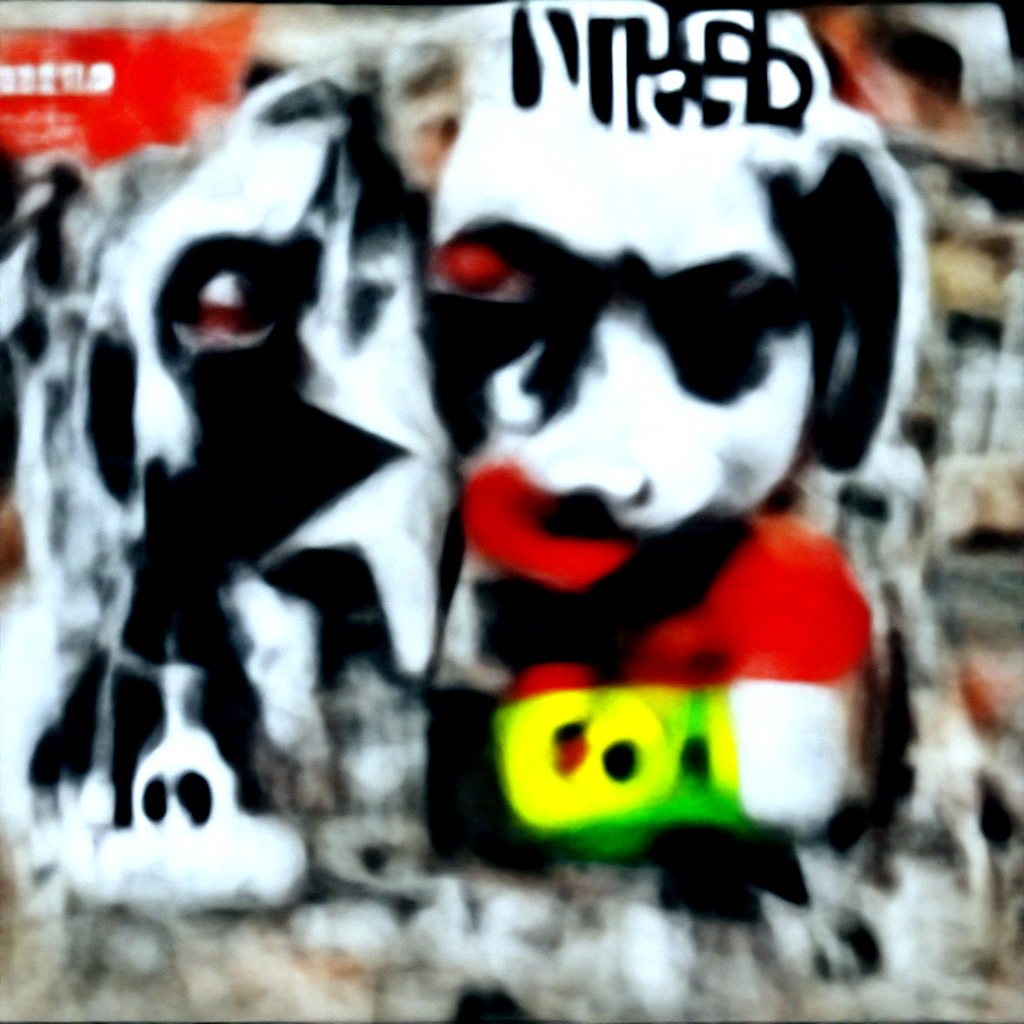

In [ ]:
#@title
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =   10#@param{type: 'number'}
n_batches =   3#@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = '10' #@param{type: 'string'}
resume_from_frame = '5' #@param{type: 'string'}
retain_overwritten_frames = True #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create 1st video

In [ ]:
#@title
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
    # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  run =  0#@param
  latest_run = run

  folder = batch_name #@param

  final_frame = 'final_frame'


  init_frame = 0#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  if last_frame == 'final_frame':
   last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
   print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')


# 3. 2nd Batch Settings


In [ ]:
#@title
#@markdown ####**Basic Settings:**
suffix_batch_name = "clipguide_100000_3D"#@param{type: 'string'}
batch_name = f'{base_batch_name}_2nd_{suffix_batch_name}'

local_steps = 333#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
steps = global_steps if use_global_steps else local_steps

local_width_height = [1344, 576]#@param{type: 'raw'}
width_height = global_width_height if use_global_width_height else local_width_height

local_clip_guidance_scale =  1000#@param{type: 'number'}
clip_guidance_scale =  global_clip_guidance_scale if use_global_clip_guidance_scale else local_clip_guidance_scale

local_tv_scale =  50#@param{type: 'number'}
tv_scale =  global_tv_scale if use_global_tv_scale else local_tv_scale

local_range_scale = 0#@param{type: 'number'}
range_scale = global_range_scale if use_global_range_scale else local_range_scale

local_sat_scale = 0#@param{type: 'number'}
sat_scale = global_sat_scale if use_global_sat_scale else local_sat_scale

local_cutn_batches =   1#@param{type: 'number'}
cutn_batches =   global_cutn_batches if use_global_cutn_batches else local_cutn_batches

local_skip_augs = False#@param{type: 'boolean'}
skip_augs = global_skip_augs if use_global_skip_augs else local_skip_augs

#@markdown ---

#@markdown ####**Init Settings:**
local_init_image = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/SunsetClouds02.png" #@param{type: 'string'}
init_image = global_init_image if use_global_init_image else local_init_image

local_init_scale =  0#@param{type: 'integer'}
init_scale = global_init_scale if use_global_init_scale else local_init_scale

local_skip_steps =  83#@param{type: 'integer'}
skip_steps = global_skip_steps if use_global_skip_steps else local_skip_steps
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
createPath(batchFolder)

### Animation Settings

In [ ]:
#@title
#@markdown ####**Animation Mode:**
animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input'] {type:'string'}
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
if is_colab:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/ColoredNoise_120bpm_2frameIntroPad.mov" #@param {type: 'string'}
else:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/IMG_1170_trimmed_1.mp4" #@param {type: 'string'}
extract_nth_frame =  1#@param {type: 'number'}
video_init_seed_continuity = True #@param {type: 'boolean'}

if animation_mode == "Video Input":
  if is_colab:
      videoFramesFolder = f'/content/videoFrames'
  else:
      videoFramesFolder = f'videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    for f in pathlib.Path(f'{videoFramesFolder}').glob('*.jpg'):
      f.unlink()
  except:
    print('')
  vf = f'select=not(mod(n\,{extract_nth_frame}))'
  subprocess.run(['ffmpeg', '-i', f'{video_init_path}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
#@markdown All rotations are provided in degrees.

key_frames = True #@param {type:"boolean"}
max_frames = 60#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))

interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0: (0.0)"#@param {type:"string"}
zoom = "0:(1.0),119:(1.05),"#@param {type:"string"}
translation_x = "0: (0.0),"#@param {type:"string"}
translation_y = "0: (0.0),"#@param {type:"string"}
translation_z = "0:(0.0),59:(0.5),"#@param {type:"string"}
rotation_3d_x = "0: (0.0),"#@param {type:"string"}
rotation_3d_y = "0:(0.0),"#@param {type:"string"}
rotation_3d_z = "0:(0.0),"#@param {type:"string"}
midas_depth_model = "dpt_large"#@param {type:"string"}
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#======= TURBO MODE
#@markdown ---
#@markdown ####**Turbo Mode (3D anim only):**
#@markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
#@markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames. frame_blend_mode smooths abrupt texture changes across 2 frames.
#@markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = True #@param {type:"boolean"}
turbo_steps = "5" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames

#insist turbo be used only w 3d anim.
if turbo_mode and animation_mode != '3D':
  print('=====')
  print('Turbo mode only available with 3D animations. Disabling Turbo.')
  print('=====')
  turbo_mode = False

#@markdown ---

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 50000 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '63%' #@param ['15%', '30%', '33%' '40%', '50%', '60%', '66%', '70%', '80%', '85%'] {type: 'string'}

#======= VR MODE
#@markdown ---
#@markdown ####**VR Mode (3D anim only):**
#@markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.
#@markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
#@markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
#@markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
#@markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
#@markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
#@markdown
#@markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False #@param {type:"boolean"}
#@markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5 #@param{type:"number"}
#@markdown interpupillary distance (between the eyes)
vr_ipd = 5.0 #@param{type:"number"}

#insist turbo be used only w 3d anim.
if vr_mode and animation_mode != '3D':
  print('=====')
  print('VR mode only available with 3D animations. Disabling VR.')
  print('=====')
  turbo_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.

    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.

    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.

    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.

    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'

    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'


    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

### Extra Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [ ]:
#@title
#@markdown #**Advanced Settings**
local_set_seed = '80808' #@param{type: 'string'}
set_seed = global_set_seed if use_global_set_seed else local_set_seed

#@markdown ---
#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000
#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.
local_cut_overview = "[16]*1000" #@param {type: 'string'}
cut_overview = global_cut_overview if use_global_cut_overview else local_cut_overview

local_cut_innercut = "[8]*1000"#@param {type: 'string'}
cut_innercut = global_cut_innercut if use_global_cut_innercut else local_cut_innercut


local_cut_ic_pow = 83.0#@param {type: 'number'}
cut_ic_pow = global_cut_ic_pow if use_global_cut_ic_pow else local_cut_ic_pow

local_cut_icgray_p = "[0.15]*1000"#@param {type: 'string'}
cut_icgray_p = global_cut_icgray_p if use_global_cut_icgray_p else local_cut_icgray_p

local_eta = 0.05#@param{type:"slider", min:0.0, max:1.0, step:0.01}
eta = global_eta if use_global_eta else local_eta

local_clamp_grad = True #@param{type: 'boolean'}
clamp_grad = global_clamp_grad if use_global_clamp_grad else local_clamp_grad

local_clamp_max = 0.003#@param{type:"slider", min:0.0, max:1.0, step:0.001}
clamp_max = global_clamp_max if use_global_clamp_max else local_clamp_max

local_randomize_class = True #@param{type: 'boolean'}
randomize_class = global_randomize_class if use_global_randomize_class else local_randomize_class

local_clip_denoised = True #@param{type: 'boolean'}
clip_denoised = global_clip_denoised if use_global_clip_denoised else local_clip_denoised

local_fuzzy_prompt = True #@param{type: 'boolean'}
fuzzy_prompt = global_fuzzy_prompt if use_global_fuzzy_prompt else local_fuzzy_prompt

local_rand_mag = 0.25#@param{type:"slider", min:0.0, max:1.0, step:0.01}
rand_mag = global_rand_mag if use_global_rand_mag else local_rand_mag

#@markdown ---
#@markdown ####**Perlin Noise:**
#@markdown *Perlin init will replace your init, so uncheck if using one.*
perlin_init = False  #@param{type: 'boolean'}
perlin_mode = 'gray' #@param ['mixed', 'color', 'gray']

#@markdown ---
#@markdown ####**Saving:**

intermediate_saves = 0#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}

#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps
#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.
#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)

if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

#@markdown ---

# 4. Diffuse 2nd Batch!

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =   5#@param{type: 'number'}
n_batches =   3#@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = '16' #@param{type: 'string'}
resume_from_frame = '5' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create 2nd video



In [ ]:
#@title
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
    # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  run =  0#@param
  latest_run = run

  folder = "/content/drive/MyDrive/AI/Disco_Diffusion/images_out/seacreatures_animations/seacreatures_animations_2nd_clipguide_100000_3D" #@param

  final_frame = 'final_frame'


  init_frame = 0#@param {type:"number"} This is the frame where the video will start
  last_frame = 119#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 24#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  if last_frame == 'final_frame':
   last_frame = len(glob(batchFolder+f"/{batch_name}({run})_*.png"))
   print(f'Total frames: {last_frame}')
  batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
  image_path = f"{outDirPath}/{base_batch_name}/{batch_name}({run})_%04d.png"
  filepath = f"{outDirPath}/{base_batch_name}/{batch_name}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')


# 3. 3rd Batch Settings


In [ ]:
#@title
#@markdown ####**Basic Settings:**
suffix_batch_name = "clipguide_10000_63"#@param{type: 'string'}
batch_name = f'{base_batch_name}_3rd_{suffix_batch_name}'

local_steps = 46#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
steps = global_steps if use_global_steps else local_steps

local_width_height = [1344, 576]#@param{type: 'raw'}
width_height = global_width_height if use_global_width_height else local_width_height

local_clip_guidance_scale =  10000#@param{type: 'number'}
clip_guidance_scale =  global_clip_guidance_scale if use_global_clip_guidance_scale else local_clip_guidance_scale

local_tv_scale =  50#@param{type: 'number'}
tv_scale =  global_tv_scale if use_global_tv_scale else local_tv_scale

local_range_scale = 0#@param{type: 'number'}
range_scale = global_range_scale if use_global_range_scale else local_range_scale

local_sat_scale = 0#@param{type: 'number'}
sat_scale = global_sat_scale if use_global_sat_scale else local_sat_scale

local_cutn_batches =   1#@param{type: 'number'}
cutn_batches =   global_cutn_batches if use_global_cutn_batches else local_cutn_batches

local_skip_augs = False#@param{type: 'boolean'}
skip_augs = global_skip_augs if use_global_skip_augs else local_skip_augs

#@markdown ---

#@markdown ####**Init Settings:**
local_init_image = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/1024x768_16x16_psyched02.png" #@param{type: 'string'}
init_image = global_init_image if use_global_init_image else local_init_image

local_init_scale =  2000#@param{type: 'integer'}
init_scale = global_init_scale if use_global_init_scale else local_init_scale

local_skip_steps =  167#@param{type: 'integer'}
skip_steps = global_skip_steps if use_global_skip_steps else local_skip_steps
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
createPath(batchFolder)

### Animation Settings

In [ ]:
#@title
#@markdown ####**Animation Mode:**
animation_mode = '2D' #@param ['None', '2D', '3D', 'Video Input'] {type:'string'}
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
if is_colab:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/ColoredNoise_120bpm_2frameIntroPad.mov" #@param {type: 'string'}
else:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/IMG_1170_trimmed_1.mp4" #@param {type: 'string'}
extract_nth_frame =  1#@param {type: 'number'}
video_init_seed_continuity = True #@param {type: 'boolean'}

if animation_mode == "Video Input":
  if is_colab:
      videoFramesFolder = f'/content/videoFrames'
  else:
      videoFramesFolder = f'videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    for f in pathlib.Path(f'{videoFramesFolder}').glob('*.jpg'):
      f.unlink()
  except:
    print('')
  vf = f'select=not(mod(n\,{extract_nth_frame}))'
  subprocess.run(['ffmpeg', '-i', f'{video_init_path}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
#@markdown All rotations are provided in degrees.

key_frames = True #@param {type:"boolean"}
max_frames = 120#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))

interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0: (0.0)"#@param {type:"string"}
zoom = "12: (1.0), 107: (1.3333)"#@param {type:"string"}
translation_x = "12: (0.0), 107: (0.0)"#@param {type:"string"}
translation_y = "0: (0.0),"#@param {type:"string"}
translation_z = "0:(0.0),"#@param {type:"string"}
rotation_3d_x = "0: (0.0),"#@param {type:"string"}
rotation_3d_y = "0:(0.0),"#@param {type:"string"}
rotation_3d_z = "0:(0.0),"#@param {type:"string"}
midas_depth_model = "dpt_large"#@param {type:"string"}
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#======= TURBO MODE
#@markdown ---
#@markdown ####**Turbo Mode (3D anim only):**
#@markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
#@markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames. frame_blend_mode smooths abrupt texture changes across 2 frames.
#@markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = False #@param {type:"boolean"}
turbo_steps = "2" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames

#insist turbo be used only w 3d anim.
if turbo_mode and animation_mode != '3D':
  print('=====')
  print('Turbo mode only available with 3D animations. Disabling Turbo.')
  print('=====')
  turbo_mode = False

#@markdown ---

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 10000 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '63%' #@param ['15%', '30%', '33%' '40%', '50%', '60%', '66%', '70%', '80%', '85%'] {type: 'string'}

#======= VR MODE
#@markdown ---
#@markdown ####**VR Mode (3D anim only):**
#@markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.
#@markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
#@markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
#@markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
#@markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
#@markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
#@markdown
#@markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False #@param {type:"boolean"}
#@markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5 #@param{type:"number"}
#@markdown interpupillary distance (between the eyes)
vr_ipd = 5.0 #@param{type:"number"}

#insist turbo be used only w 3d anim.
if vr_mode and animation_mode != '3D':
  print('=====')
  print('VR mode only available with 3D animations. Disabling VR.')
  print('=====')
  turbo_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.

    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.

    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.

    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.

    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'

    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'


    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

### Extra Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [ ]:
#@title
#@markdown #**Advanced Settings**
local_set_seed = '80808' #@param{type: 'string'}
set_seed = global_set_seed if use_global_set_seed else local_set_seed

#@markdown ---
#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000
#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.
local_cut_overview = "[12]*500+[4]*500" #@param {type: 'string'}
cut_overview = global_cut_overview if use_global_cut_overview else local_cut_overview

local_cut_innercut = "[4]*500+[12]*500"#@param {type: 'string'}
cut_innercut = global_cut_innercut if use_global_cut_innercut else local_cut_innercut


local_cut_ic_pow = 1.875#@param {type: 'number'}
cut_ic_pow = global_cut_ic_pow if use_global_cut_ic_pow else local_cut_ic_pow

local_cut_icgray_p = "[0.15]*1000"#@param {type: 'string'}
cut_icgray_p = global_cut_icgray_p if use_global_cut_icgray_p else local_cut_icgray_p

local_eta = 0.05#@param{type:"slider", min:0.0, max:1.0, step:0.01}
eta = global_eta if use_global_eta else local_eta

local_clamp_grad = True #@param{type: 'boolean'}
clamp_grad = global_clamp_grad if use_global_clamp_grad else local_clamp_grad

local_clamp_max = 0.003#@param{type:"slider", min:0.0, max:1.0, step:0.001}
clamp_max = global_clamp_max if use_global_clamp_max else local_clamp_max

local_randomize_class = True #@param{type: 'boolean'}
randomize_class = global_randomize_class if use_global_randomize_class else local_randomize_class

local_clip_denoised = True #@param{type: 'boolean'}
clip_denoised = global_clip_denoised if use_global_clip_denoised else local_clip_denoised

local_fuzzy_prompt = True #@param{type: 'boolean'}
fuzzy_prompt = global_fuzzy_prompt if use_global_fuzzy_prompt else local_fuzzy_prompt

local_rand_mag = 0.25#@param{type:"slider", min:0.0, max:1.0, step:0.01}
rand_mag = global_rand_mag if use_global_rand_mag else local_rand_mag

#@markdown ---
#@markdown ####**Perlin Noise:**
#@markdown *Perlin init will replace your init, so uncheck if using one.*
perlin_init = False  #@param{type: 'boolean'}
perlin_mode = 'gray' #@param ['mixed', 'color', 'gray']

#@markdown ---
#@markdown ####**Saving:**

intermediate_saves = 0#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}

#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps
#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.
#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)

if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

#@markdown ---

# 4. Diffuse 3rd Batch!

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =   5#@param{type: 'number'}
n_batches =   3#@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = '16' #@param{type: 'string'}
resume_from_frame = '5' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create 3rd video



In [ ]:
#@title
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
    # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  run =  0#@param
  latest_run = run

  folder = batch_name #@param

  final_frame = 'final_frame'


  init_frame = 0#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  if last_frame == 'final_frame':
   last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
   print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')


In [ ]:
#@title
#@title


# 3. 4th Batch Settings


In [ ]:
#@markdown ####**Basic Settings:**
suffix_batch_name = "clipguide_70000"#@param{type: 'string'}
batch_name = f'{base_batch_name}_4th_{suffix_batch_name}'

local_steps = 666#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
steps = global_steps if use_global_steps else local_steps

local_width_height = [1344, 576]#@param{type: 'raw'}
width_height = global_width_height if use_global_width_height else local_width_height

local_clip_guidance_scale =  70000#@param{type: 'number'}
clip_guidance_scale =  global_clip_guidance_scale if use_global_clip_guidance_scale else local_clip_guidance_scale

local_tv_scale =  50#@param{type: 'number'}
tv_scale =  global_tv_scale if use_global_tv_scale else local_tv_scale

local_range_scale = 0#@param{type: 'number'}
range_scale = global_range_scale if use_global_range_scale else local_range_scale

local_sat_scale = 0#@param{type: 'number'}
sat_scale = global_sat_scale if use_global_sat_scale else local_sat_scale

local_cutn_batches =   1#@param{type: 'number'}
cutn_batches =   global_cutn_batches if use_global_cutn_batches else local_cutn_batches

local_skip_augs = False#@param{type: 'boolean'}
skip_augs = global_skip_augs if use_global_skip_augs else local_skip_augs

#@markdown ---

#@markdown ####**Init Settings:**
local_init_image = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/SunsetClouds03.png" #@param{type: 'string'}
init_image = global_init_image if use_global_init_image else local_init_image

local_init_scale =  166#@param{type: 'integer'}
init_scale = global_init_scale if use_global_init_scale else local_init_scale

local_skip_steps =  166#@param{type: 'integer'}
skip_steps = global_skip_steps if use_global_skip_steps else local_skip_steps
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
createPath(batchFolder)

### Animation Settings

In [ ]:
#@title
#@markdown ####**Animation Mode:**
animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input'] {type:'string'}
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
if is_colab:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/ColoredNoise_120bpm_2frameIntroPad.mov" #@param {type: 'string'}
else:
    video_init_path = "/content/drive/MyDrive/AI_Art_Inputs/DiscoDiffusion init_clips/IMG_1170_trimmed_1.mp4" #@param {type: 'string'}
extract_nth_frame =  1#@param {type: 'number'}
video_init_seed_continuity = True #@param {type: 'boolean'}

if animation_mode == "Video Input":
  if is_colab:
      videoFramesFolder = f'/content/videoFrames'
  else:
      videoFramesFolder = f'videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    for f in pathlib.Path(f'{videoFramesFolder}').glob('*.jpg'):
      f.unlink()
  except:
    print('')
  vf = f'select=not(mod(n\,{extract_nth_frame}))'
  subprocess.run(['ffmpeg', '-i', f'{video_init_path}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
#@markdown All rotations are provided in degrees.

key_frames = True #@param {type:"boolean"}
max_frames = 120#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))

interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0: (0.0)"#@param {type:"string"}
zoom = "0:(1.0)"#@param {type:"string"}
translation_x = "0: (0.0), 29: (1.0), 59: (0.0), 89: (-1.0), 119: (0.0), "#@param {type:"string"}
translation_y = "0: (0.0),"#@param {type:"string"}
translation_z = "0:(0.0),"#@param {type:"string"}
rotation_3d_x = "0: (0.0),"#@param {type:"string"}
rotation_3d_y = "0:(0.0),"#@param {type:"string"}
rotation_3d_z = "0:(0.0),"#@param {type:"string"}
midas_depth_model = "dpt_large"#@param {type:"string"}
midas_weight = 0.3#@param {type:"number"}
near_plane = 200#@param {type:"number"}
far_plane = 10000#@param {type:"number"}
fov = 40#@param {type:"number"}
padding_mode = 'border'#@param {type:"string"}
sampling_mode = 'bicubic'#@param {type:"string"}

#======= TURBO MODE
#@markdown ---
#@markdown ####**Turbo Mode (3D anim only):**
#@markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
#@markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames. frame_blend_mode smooths abrupt texture changes across 2 frames.
#@markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = False #@param {type:"boolean"}
turbo_steps = "2" #@param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10 # frames

#insist turbo be used only w 3d anim.
if turbo_mode and animation_mode != '3D':
  print('=====')
  print('Turbo mode only available with 3D animations. Disabling Turbo.')
  print('=====')
  turbo_mode = False

#@markdown ---

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 10000 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '37%' #@param ['15%', '30%', '33%' '40%', '50%', '60%', '66%', '70%', '80%', '85%'] {type: 'string'}

#======= VR MODE
#@markdown ---
#@markdown ####**VR Mode (3D anim only):**
#@markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.
#@markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
#@markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
#@markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
#@markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
#@markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
#@markdown
#@markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False #@param {type:"boolean"}
#@markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5 #@param{type:"number"}
#@markdown interpupillary distance (between the eyes)
vr_ipd = 5.0 #@param{type:"number"}

#insist turbo be used only w 3d anim.
if vr_mode and animation_mode != '3D':
  print('=====')
  print('VR mode only available with 3D animations. Disabling VR.')
  print('=====')
  turbo_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.

    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.

    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.

    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.

    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'

    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'


    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

### Extra Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [ ]:
#@markdown #**Advanced Settings**
local_set_seed = '80808' #@param{type: 'string'}
set_seed = global_set_seed if use_global_set_seed else local_set_seed

#@markdown ---
#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000
#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.
local_cut_overview = "[16]*100+[14]*100+[12]*100+[10]*100+[8]*100+[6]*100+[4]*100+[2]*100+[0]*100+[8]*100" #@param {type: 'string'}
cut_overview = global_cut_overview if use_global_cut_overview else local_cut_overview

local_cut_innercut = "[0]*100+[2]*100+[4]*100+[6]*100+[8]*100+[10]*100+[12]*100+[14]*100+[16]*100+[8]*100"#@param {type: 'string'}
cut_innercut = global_cut_innercut if use_global_cut_innercut else local_cut_innercut


local_cut_ic_pow = 1.0#@param {type: 'number'}
cut_ic_pow = global_cut_ic_pow if use_global_cut_ic_pow else local_cut_ic_pow

local_cut_icgray_p = "[0.15]*1000"#@param {type: 'string'}
cut_icgray_p = global_cut_icgray_p if use_global_cut_icgray_p else local_cut_icgray_p

local_eta = 0.05#@param{type:"slider", min:0.0, max:1.0, step:0.01}
eta = global_eta if use_global_eta else local_eta

local_clamp_grad = True #@param{type: 'boolean'}
clamp_grad = global_clamp_grad if use_global_clamp_grad else local_clamp_grad

local_clamp_max = 0.003#@param{type:"slider", min:0.0, max:1.0, step:0.001}
clamp_max = global_clamp_max if use_global_clamp_max else local_clamp_max

local_randomize_class = True #@param{type: 'boolean'}
randomize_class = global_randomize_class if use_global_randomize_class else local_randomize_class

local_clip_denoised = True #@param{type: 'boolean'}
clip_denoised = global_clip_denoised if use_global_clip_denoised else local_clip_denoised

local_fuzzy_prompt = True #@param{type: 'boolean'}
fuzzy_prompt = global_fuzzy_prompt if use_global_fuzzy_prompt else local_fuzzy_prompt

local_rand_mag = 0.25#@param{type:"slider", min:0.0, max:1.0, step:0.01}
rand_mag = global_rand_mag if use_global_rand_mag else local_rand_mag

#@markdown ---
#@markdown ####**Perlin Noise:**
#@markdown *Perlin init will replace your init, so uncheck if using one.*
perlin_init = True  #@param{type: 'boolean'}
perlin_mode = 'gray' #@param ['mixed', 'color', 'gray']

#@markdown ---
#@markdown ####**Saving:**

intermediate_saves = 0#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}

#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps
#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.
#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)

if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

#@markdown ---

# 4. Diffuse 4th Batch!

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =   5#@param{type: 'number'}
n_batches =   3#@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = '10' #@param{type: 'string'}
resume_from_frame = '5' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create 4th video



In [ ]:
#@title
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
    # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  run =  0#@param
  latest_run = run

  folder = batch_name #@param

  final_frame = 'final_frame'


  init_frame = 0#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  if last_frame == 'final_frame':
   last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
   print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')


# 4. 5th Batch

In [ ]:
#@title

#@markdown ####**Basic Settings:**
suffix_batch_name = "clipguide_60000"#@param{type: 'string'}
batch_name = f'{base_batch_name}_3rd_{suffix_batch_name}'

local_steps = 46#@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
steps = global_steps if use_global_steps else local_steps

local_width_height = [1344, 576]#@param{type: 'raw'}
width_height = global_width_height if use_global_width_height else local_width_height

local_clip_guidance_scale =  60000#@param{type: 'number'}
clip_guidance_scale =  global_clip_guidance_scale if use_global_clip_guidance_scale else local_clip_guidance_scale

local_tv_scale =  50#@param{type: 'number'}
tv_scale =  global_tv_scale if use_global_tv_scale else local_tv_scale

local_range_scale = 0#@param{type: 'number'}
range_scale = global_range_scale if use_global_range_scale else local_range_scale

local_sat_scale = 0#@param{type: 'number'}
sat_scale = global_sat_scale if use_global_sat_scale else local_sat_scale

local_cutn_batches =   1#@param{type: 'number'}
cutn_batches =   global_cutn_batches if use_global_cutn_batches else local_cutn_batches

local_skip_augs = False#@param{type: 'boolean'}
skip_augs = global_skip_augs if use_global_skip_augs else local_skip_augs

#@markdown ---

#@markdown ####**Init Settings:**
local_init_image = "/content/drive/MyDrive/AI_Art_Inputs/ChaosEngines/SunsetClouds03.png" #@param{type: 'string'}
init_image = global_init_image if use_global_init_image else local_init_image

local_init_scale =  2000#@param{type: 'integer'}
init_scale = global_init_scale if use_global_init_scale else local_init_scale

local_skip_steps =  167#@param{type: 'integer'}
skip_steps = global_skip_steps if use_global_skip_steps else local_skip_steps
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{base_batch_name}/{batch_name}'
createPath(batchFolder)

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =   5#@param{type: 'number'}
n_batches =   3#@param{type: 'number'}

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

batch_size = 1

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = '16' #@param{type: 'string'}
resume_from_frame = '5' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
  else:
    start_frame = int(resume_from_frame)+1
    if animation_mode != '3D' and turbo_mode == True and start_frame > turbo_preroll and start_frame % int(turbo_steps) != 0:
      start_frame = start_frame - (start_frame % int(turbo_steps))
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while os.path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'diffusion_sampling_mode': diffusion_sampling_mode,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'video_init_seed_continuity': video_init_seed_continuity,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'translation_z': translation_z,
    'rotation_3d_x': rotation_3d_x,
    'rotation_3d_y': rotation_3d_y,
    'rotation_3d_z': rotation_3d_z,
    'midas_depth_model': midas_depth_model,
    'midas_weight': midas_weight,
    'near_plane': near_plane,
    'far_plane': far_plane,
    'fov': fov,
    'padding_mode': padding_mode,
    'sampling_mode': sampling_mode,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'translation_z_series':translation_z_series,
    'rotation_3d_x_series':rotation_3d_x_series,
    'rotation_3d_y_series':rotation_3d_y_series,
    'rotation_3d_z_series':rotation_3d_z_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
#@title
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == True:
  print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')

else:
    # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  run =  0#@param
  latest_run = run

  folder = batch_name #@param

  final_frame = 'final_frame'


  init_frame = 0#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  # view_video_in_cell = True #@param {type: 'boolean'}

  if last_frame == 'final_frame':
   last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
   print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready and saved to the images folder")

  # if view_video_in_cell:
  #     mp4 = open(filepath,'rb').read()
  #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')
